In [1]:
import pandas as pd
import os
import glob

sampling_rate = 50 

# Load first 7 CSV files
folder_path = r'C:\Users\Admin\Documents\without yaw'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
csv_files.sort()
csv_files = csv_files[:7]

# Get lengths and durations
file_lengths = []
file_durations = []

for file in csv_files:
    length = len(pd.read_csv(file))
    duration_sec = length / sampling_rate
    file_lengths.append(length)
    file_durations.append(duration_sec)

# Find the index of the largest file
largest_file_index = file_lengths.index(max(file_lengths))

# Print results
for i, (length, duration) in enumerate(zip(file_lengths, file_durations)):
    print(f"File {i+1}: {length} rows, {duration:.2f} seconds ({duration/60:.2f} minutes)")

print(f"\nThe largest file is file number: {largest_file_index + 1}")


File 1: 48381 rows, 967.62 seconds (16.13 minutes)
File 2: 87475 rows, 1749.50 seconds (29.16 minutes)
File 3: 112164 rows, 2243.28 seconds (37.39 minutes)
File 4: 270377 rows, 5407.54 seconds (90.13 minutes)
File 5: 184867 rows, 3697.34 seconds (61.62 minutes)
File 6: 193799 rows, 3875.98 seconds (64.60 minutes)
File 7: 41261 rows, 825.22 seconds (13.75 minutes)

The largest file is file number: 4


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.preprocessing import StandardScaler

sampling_rate = 50
dt = 1 / sampling_rate
seq_len = 75

input_columns = ['SW_pos_obd', 'brake_pressure_obd', 'LatAcc_obd', 'speedo_obd',
                 'VelFR_obd', 'VelFL_obd', 'VelRR_obd', 'VelRL_obd', 'Yawrate_obd']
target_columns = ['ins_vel_hor_x', 'ins_vel_hor_y', 'delta_x_v', 'delta_y_v']

class SingleStepDataset(Dataset):
    def __init__(self, data, input_columns, target_columns, seq_len, input_scaler, target_scaler):
        self.seq_len = seq_len
        inputs = data[input_columns].values
        targets = data[target_columns].values
        self.inputs = input_scaler.transform(inputs)
        self.targets = target_scaler.transform(targets)

    def __len__(self):
        return len(self.inputs) - self.seq_len

    def __getitem__(self, idx):
        x = self.inputs[idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def load_file_with_delta(file):
    df = pd.read_csv(file)
    df['delta_x_v'] = df['ins_vel_hor_x'] * dt
    df['delta_y_v'] = df['ins_vel_hor_y'] * dt
    return df

# Load files
folder_path = r'C:\Users\Admin\Documents\without yaw'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
csv_files.sort()
csv_files = csv_files[:7]  # first 7 files

# Load all dataframes with delta columns
dfs = [load_file_with_delta(f) for f in csv_files]

# Fixed assignment of splits:
test_df = dfs[3]   # file number 4 (index 3)
val_df = dfs[5]    # file number 6 (index 5)
train_dfs = [dfs[i] for i in range(len(dfs)) if i not in (3, 5)]

# Combine train data for scaler fitting
train_df_combined = pd.concat(train_dfs, ignore_index=True)

input_scaler = StandardScaler().fit(train_df_combined[input_columns].values)
target_scaler = StandardScaler().fit(train_df_combined[target_columns].values)

# Create datasets
train_datasets = [SingleStepDataset(df, input_columns, target_columns, seq_len, input_scaler, target_scaler) for df in train_dfs]
val_dataset = SingleStepDataset(val_df, input_columns, target_columns, seq_len, input_scaler, target_scaler)
test_dataset = SingleStepDataset(test_df, input_columns, target_columns, seq_len, input_scaler, target_scaler)

# Concatenate train datasets
train_dataset = ConcatDataset(train_datasets)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data split: test=file 4, val=file 6, train=others. Ready for training.")

Data split: test=file 4, val=file 6, train=others. Ready for training.


In [5]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

# LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Hyperparameters
input_size = len(input_columns)
hidden_size = 64
num_layers = 3
output_size = len(target_columns)
dropout = 0.2
learning_rate = 0.0005
weight_decay = 1e-5
epochs = 50
patience = 10

# Initialize model, loss, optimizer
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
best_val_loss = np.inf
early_stopping_counter = 0
print("Model initialized.")

Model initialized.


In [6]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch, y_batch
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val, y_val
            predictions = model(x_val)
            loss = criterion(predictions, y_val)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model4.pth')
        print(f"Best model saved at epoch {epoch+1}.")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/50 - Train Loss: 0.0747, Val Loss: 0.0041
Best model saved at epoch 1.
Epoch 2/50 - Train Loss: 0.0620, Val Loss: 0.0089
Epoch 3/50 - Train Loss: 0.0591, Val Loss: 0.0062
Epoch 4/50 - Train Loss: 0.0567, Val Loss: 0.0052
Epoch 5/50 - Train Loss: 0.0554, Val Loss: 0.0117
Epoch 6/50 - Train Loss: 0.0524, Val Loss: 0.0076
Epoch 7/50 - Train Loss: 0.0499, Val Loss: 0.0091
Epoch 8/50 - Train Loss: 0.0472, Val Loss: 0.0106
Epoch 9/50 - Train Loss: 0.0450, Val Loss: 0.0150
Epoch 10/50 - Train Loss: 0.0426, Val Loss: 0.0238
Epoch 11/50 - Train Loss: 0.0407, Val Loss: 0.0238
Early stopping triggered.


In [7]:
# Load best model
model.load_state_dict(torch.load('best_model4.pth'))
model.eval()
print("Best model loaded.")

# Predictions
preds, targets = [], []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test
        pred = model(x_test).cpu().numpy()
        preds.append(pred)
        targets.append(y_test.numpy())
preds = np.concatenate(preds, axis=0)
targets = np.concatenate(targets, axis=0)
preds_unscaled = target_scaler.inverse_transform(preds)
targets_unscaled = target_scaler.inverse_transform(targets)


Best model loaded.



--- ins_vel_hor_x ---
MSE : 0.0196
RMSE: 0.1400
MAE : 0.0968
R²  : 0.9981


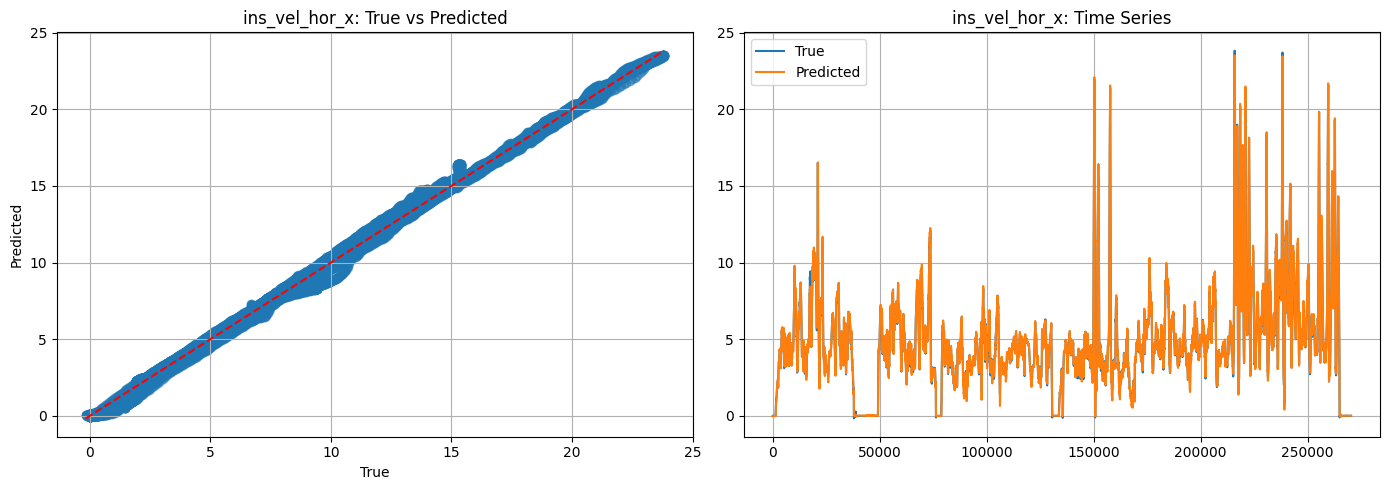


--- ins_vel_hor_y ---
MSE : 0.0004
RMSE: 0.0196
MAE : 0.0125
R²  : 0.9617


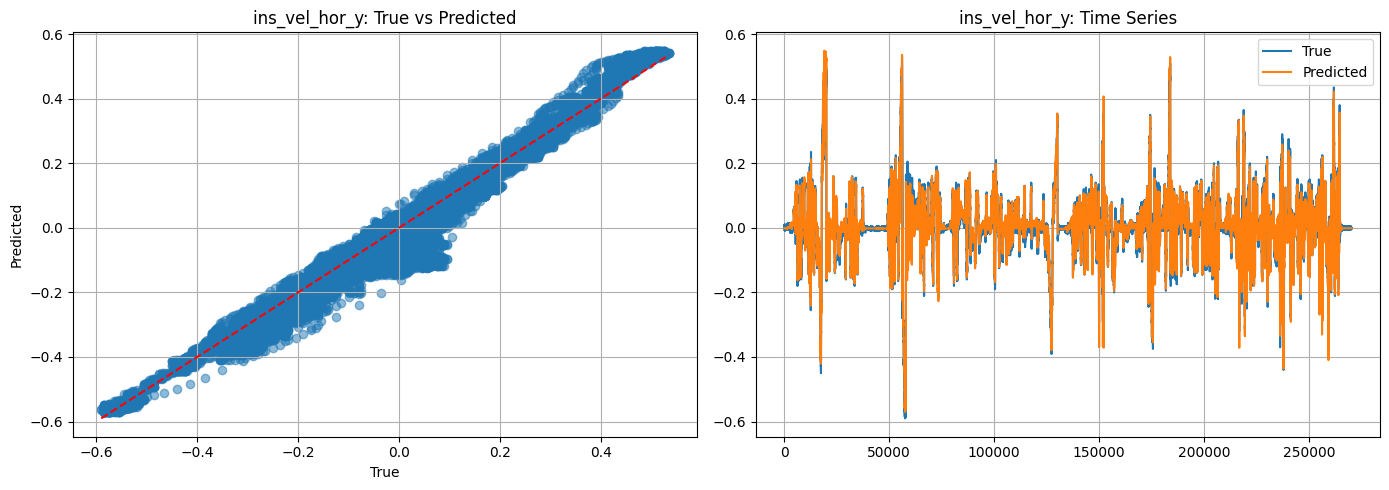


--- delta_x_v ---
MSE : 0.0000
RMSE: 0.0029
MAE : 0.0019
R²  : 0.9980


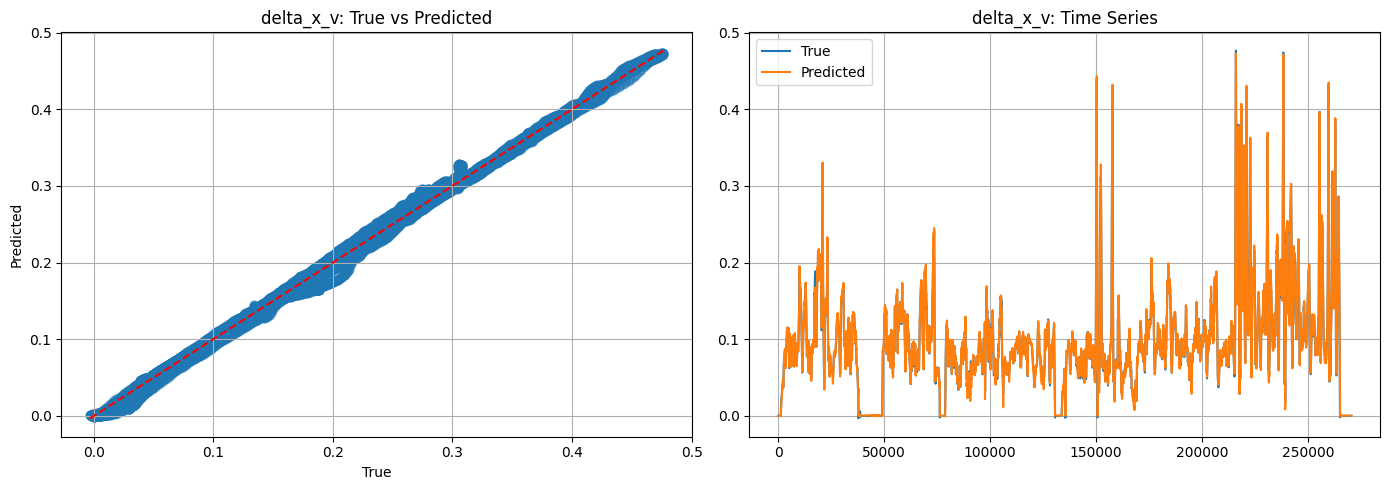


--- delta_y_v ---
MSE : 0.0000
RMSE: 0.0004
MAE : 0.0002
R²  : 0.9612


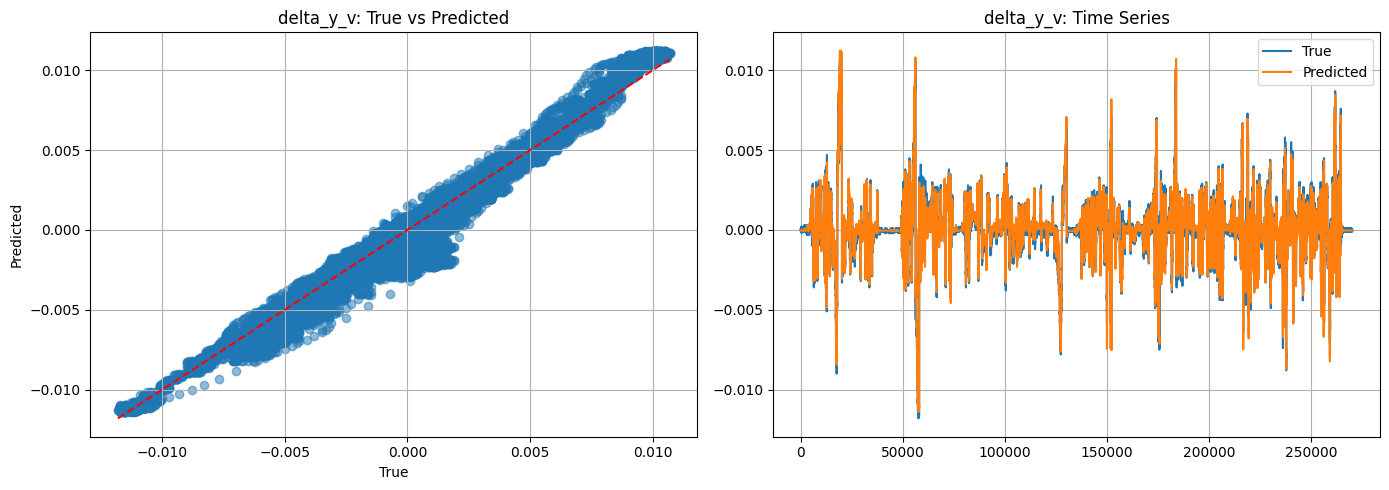

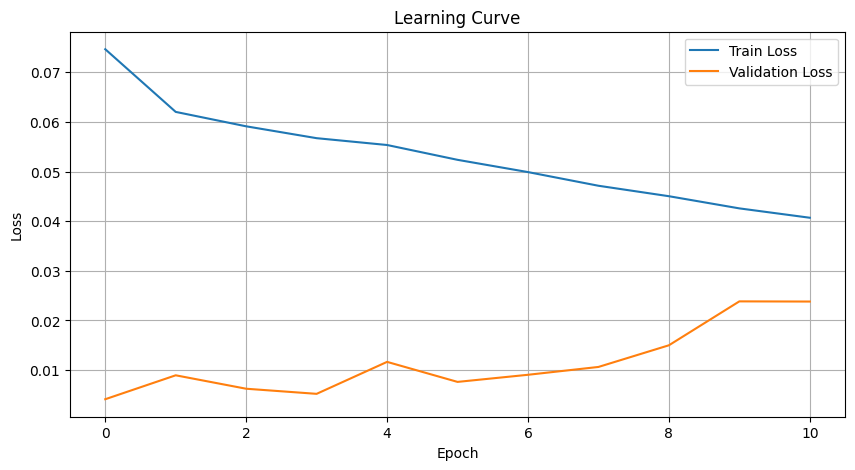

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_size = sum(len(df) for df in train_dfs)
val_size = len(val_df)
test_size = len(test_df)

# Metrics and plots
metrics = {}
for i, name in enumerate(target_columns):
    y_true = targets_unscaled[:, i]
    y_pred = preds_unscaled[:, i]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

    print(f"\n--- {name} ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    axes[0].set_title(f'{name}: True vs Predicted')
    axes[0].set_xlabel('True')
    axes[0].set_ylabel('Predicted')
    axes[0].grid(True)

    axes[1].plot(y_true, label='True')
    axes[1].plot(y_pred, label='Predicted')
    axes[1].set_title(f'{name}: Time Series')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

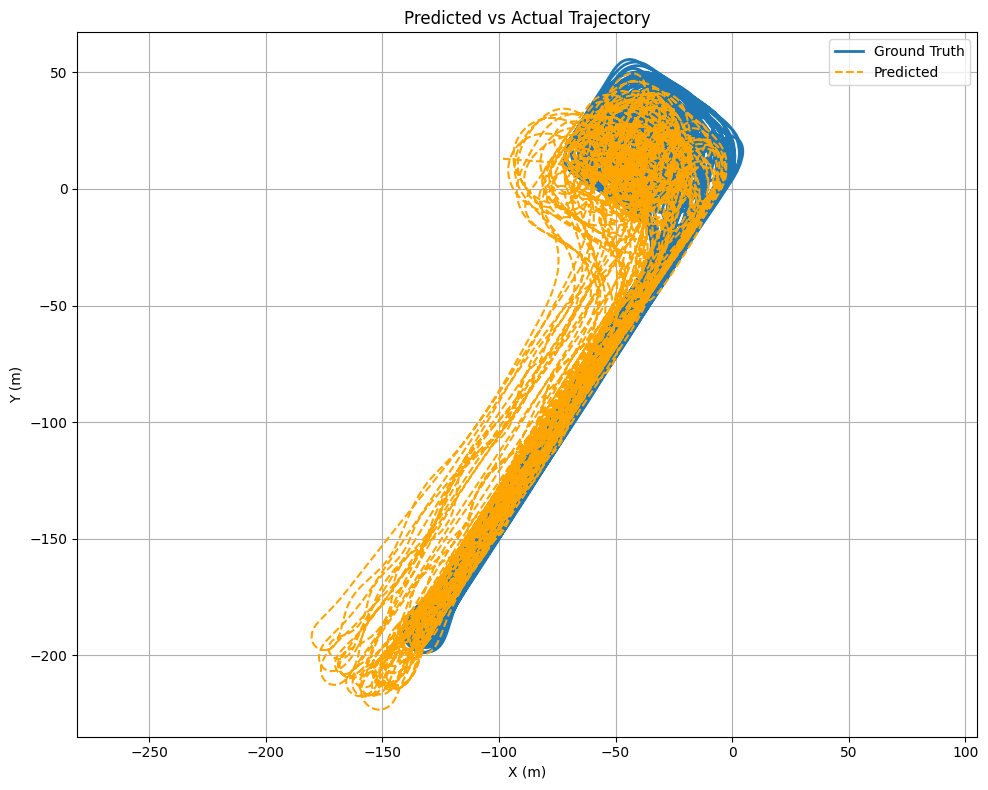

In [9]:
# use the test_df only
yaw = test_df['ins_yaw'].values[seq_len : seq_len + len(preds_unscaled)]
yaw = -np.deg2rad(yaw)

# Extract predicted local deltas
pred_dx_v = preds_unscaled[:, 2]
pred_dy_v = preds_unscaled[:, 3]

# Convert to global frame deltas
delta_x_f = pred_dx_v * np.cos(yaw) - pred_dy_v * np.sin(yaw)
delta_y_f = pred_dx_v * np.sin(yaw) + pred_dy_v * np.cos(yaw)

# Starting position (at the first prediction time)
start_x = test_df['ins_pos_rel_x'].values[seq_len]
start_y = test_df['ins_pos_rel_y'].values[seq_len]

# Cumulative sum to reconstruct global trajectory
pred_pos_x = np.cumsum(delta_x_f) + start_x
pred_pos_y = np.cumsum(delta_y_f) + start_y

# Ground truth positions
gt_pos_x = test_df['ins_pos_rel_x'].values[seq_len : seq_len + len(preds_unscaled)]
gt_pos_y = test_df['ins_pos_rel_y'].values[seq_len : seq_len + len(preds_unscaled)]

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x, pred_pos_y, label='Predicted', linestyle='--', color='orange')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.savefig("Trajectory_full")
plt.show()


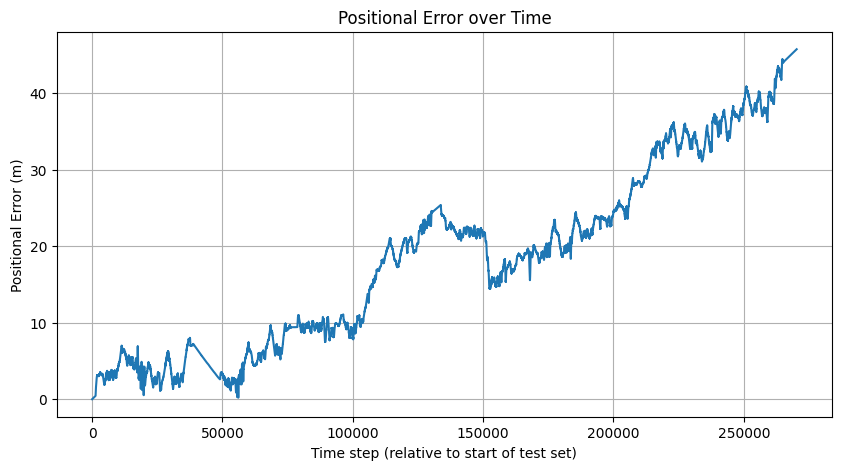

Maximum positional error: 45.757 meters
time: 5406.02 seconds (90.10 minutes)


<Figure size 640x480 with 0 Axes>

In [10]:
# positional error (euclidean distance) for the full trajectory
errors = np.sqrt((gt_pos_x - pred_pos_x)**2 + (gt_pos_y - pred_pos_y)**2)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(errors)
plt.xlabel('Time step (relative to start of test set)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error over Time')
plt.grid(True)
plt.show()
plt.savefig("Positional_Error_over_Time")

# Find the maximum positional error and its time step
max_error = np.max(errors)
max_error_index = np.argmax(errors)

print(f"Maximum positional error: {max_error:.3f} meters")

# Convert to time in seconds or minutes (50 Hz sampling rate)
max_error_time_seconds = max_error_index / 50

max_error_time_minutes = max_error_time_seconds / 60
print(f"time: {max_error_time_seconds:.2f} seconds ({max_error_time_minutes:.2f} minutes)")




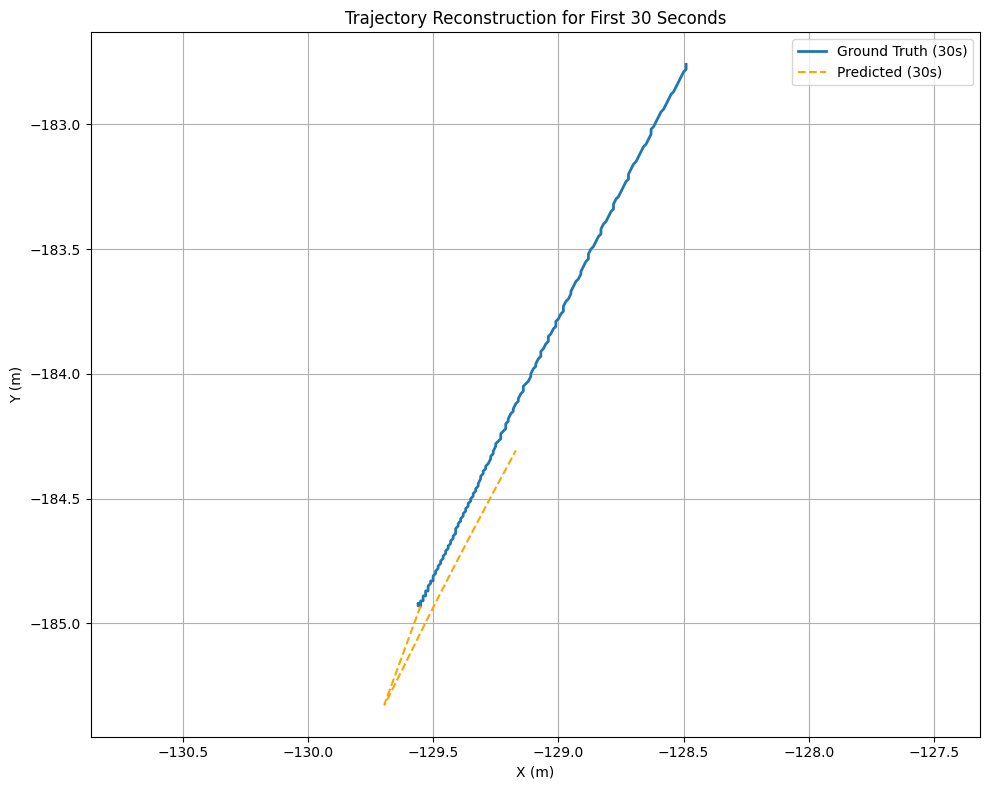

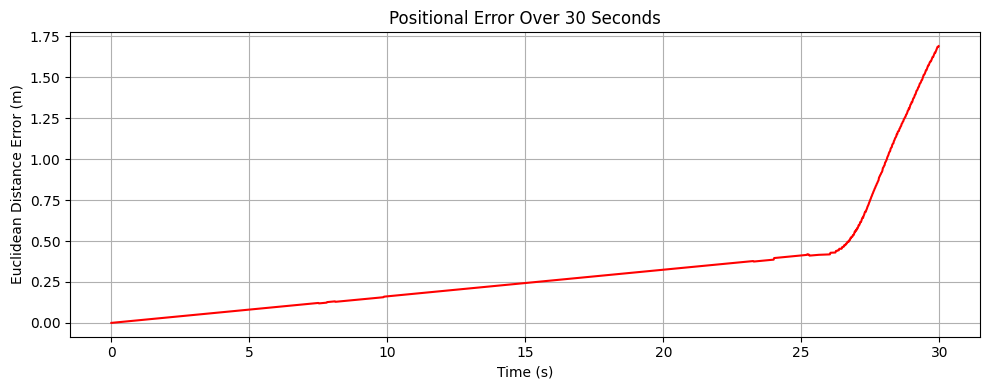


🔹 Minimum error: 0.000 meters at timestep 0 (time = 0.00 s)
🔹 Maximum error: 1.690 meters at timestep 1499 (time = 29.98 s)


In [11]:
# Duration parameters
sampling_rate = 50  # Hz
duration_sec = 30
timesteps = duration_sec * sampling_rate  # 1500

# Slice predictions and corresponding ground truth
preds_30s = preds_unscaled[:timesteps]

# Extract yaw for the same range
yaw = test_df['ins_yaw'].values[seq_len : seq_len + timesteps]
yaw = -np.deg2rad(yaw)

# Extract predicted local deltas
pred_dx_v = preds_30s[:, 2]
pred_dy_v = preds_30s[:, 3]

# Convert to global frame deltas
delta_x_f = pred_dx_v * np.cos(yaw) - pred_dy_v * np.sin(yaw)
delta_y_f = pred_dx_v * np.sin(yaw) + pred_dy_v * np.cos(yaw)

# Starting position (first position used in 30s prediction)
start_x = test_df['ins_pos_rel_x'].values[seq_len]
start_y = test_df['ins_pos_rel_y'].values[seq_len]

# Cumulative sum to reconstruct global trajectory
pred_pos_x = np.cumsum(delta_x_f) + start_x
pred_pos_y = np.cumsum(delta_y_f) + start_y

# Ground truth for comparison
gt_pos_x = test_df['ins_pos_rel_x'].values[seq_len : seq_len + timesteps]
gt_pos_y = test_df['ins_pos_rel_y'].values[seq_len : seq_len + timesteps]

# Plot
plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth (30s)', linewidth=2)
plt.plot(pred_pos_x, pred_pos_y, label='Predicted (30s)', linestyle='--', color='orange')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Trajectory Reconstruction for First 30 Seconds')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.savefig("Trajectory_30s")
plt.show()

# Euclidean Error over Time
euclidean_error = np.sqrt((pred_pos_x - gt_pos_x) ** 2 + (pred_pos_y - gt_pos_y) ** 2)

plt.figure(figsize=(10, 4))
time_axis = np.arange(timesteps) / sampling_rate  # in seconds
plt.plot(time_axis, euclidean_error, color='red')
plt.xlabel('Time (s)')
plt.ylabel('Euclidean Distance Error (m)')
plt.title('Positional Error Over 30 Seconds')
plt.grid(True)
plt.tight_layout()
plt.savefig("Trajectory_Error_30s")
plt.show()

# Error Statistics
min_error = np.min(euclidean_error)
max_error = np.max(euclidean_error)
min_idx = np.argmin(euclidean_error)
max_idx = np.argmax(euclidean_error)

print(f"\n🔹 Minimum error: {min_error:.3f} meters at timestep {min_idx} (time = {min_idx / sampling_rate:.2f} s)")
print(f"🔹 Maximum error: {max_error:.3f} meters at timestep {max_idx} (time = {max_idx / sampling_rate:.2f} s)")


🔹 Minimum error: 0.000 m at timestep 0 (time = 0.00 s)
🔹 Maximum error: 3.424 m at timestep 2999 (time = 59.98 s)


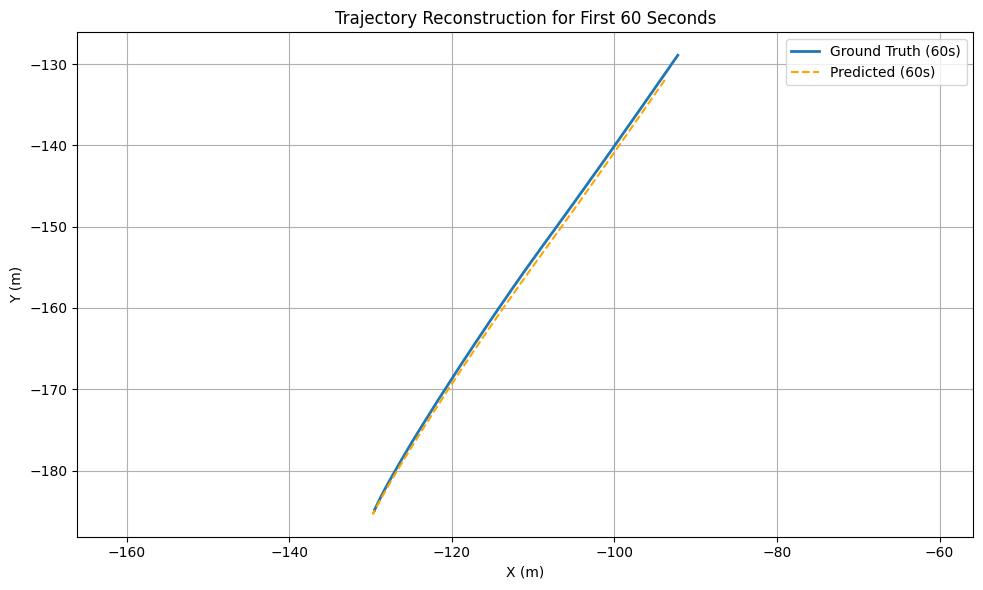

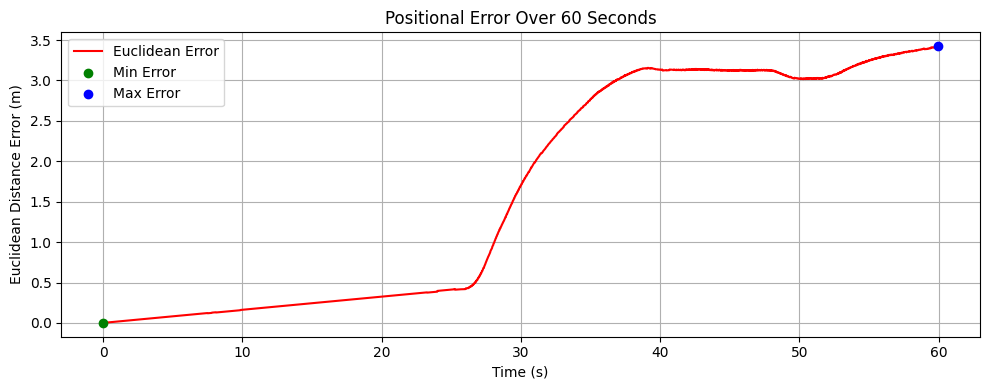

In [12]:
# Parameters
sampling_rate = 50  # Hz
duration_sec = 60
timesteps = duration_sec * sampling_rate  # 3000 samples

# Slice predictions and yaw for 60s
preds_60s = preds_unscaled[:timesteps]
yaw = test_df['ins_yaw'].values[seq_len : seq_len + timesteps]
yaw = -np.deg2rad(yaw)

# Predicted local deltas
pred_dx_v = preds_60s[:, 2]
pred_dy_v = preds_60s[:, 3]

# Convert to global frame deltas
delta_x_f = pred_dx_v * np.cos(yaw) - pred_dy_v * np.sin(yaw)
delta_y_f = pred_dx_v * np.sin(yaw) + pred_dy_v * np.cos(yaw)

# Starting position from test data
start_x = test_df['ins_pos_rel_x'].values[seq_len]
start_y = test_df['ins_pos_rel_y'].values[seq_len]

# Reconstructed predicted positions
pred_pos_x = np.cumsum(delta_x_f) + start_x
pred_pos_y = np.cumsum(delta_y_f) + start_y

# Ground truth positions
gt_pos_x = test_df['ins_pos_rel_x'].values[seq_len : seq_len + timesteps]
gt_pos_y = test_df['ins_pos_rel_y'].values[seq_len : seq_len + timesteps]

# Euclidean Distance Error
euclidean_error = np.sqrt((pred_pos_x - gt_pos_x) ** 2 + (pred_pos_y - gt_pos_y) ** 2)

# Min and Max Error Stats
min_error = np.min(euclidean_error)
max_error = np.max(euclidean_error)
min_idx = np.argmin(euclidean_error)
max_idx = np.argmax(euclidean_error)

print(f"\n🔹 Minimum error: {min_error:.3f} m at timestep {min_idx} (time = {min_idx / sampling_rate:.2f} s)")
print(f"🔹 Maximum error: {max_error:.3f} m at timestep {max_idx} (time = {max_idx / sampling_rate:.2f} s)")

# Trajectory Plot
plt.figure(figsize=(10, 6))
plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth (60s)', linewidth=2)
plt.plot(pred_pos_x, pred_pos_y, label='Predicted (60s)', linestyle='--', color='orange')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Trajectory Reconstruction for First 60 Seconds')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.savefig("Trajectory_60s")
plt.show()

#Error Curve 
plt.figure(figsize=(10, 4))
time_axis = np.arange(timesteps) / sampling_rate
plt.plot(time_axis, euclidean_error, color='red', label='Euclidean Error')
plt.scatter(min_idx / sampling_rate, min_error, color='green', label='Min Error', zorder=5)
plt.scatter(max_idx / sampling_rate, max_error, color='blue', label='Max Error', zorder=5)
plt.xlabel('Time (s)')
plt.ylabel('Euclidean Distance Error (m)')
plt.title('Positional Error Over 60 Seconds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Trajectory_Error_60s")
plt.show()



🔹 Minimum error: 0.000 m at timestep 0 (time = 0.00 s)
🔹 Maximum error: 7.012 m at timestep 11331 (time = 226.62 s)


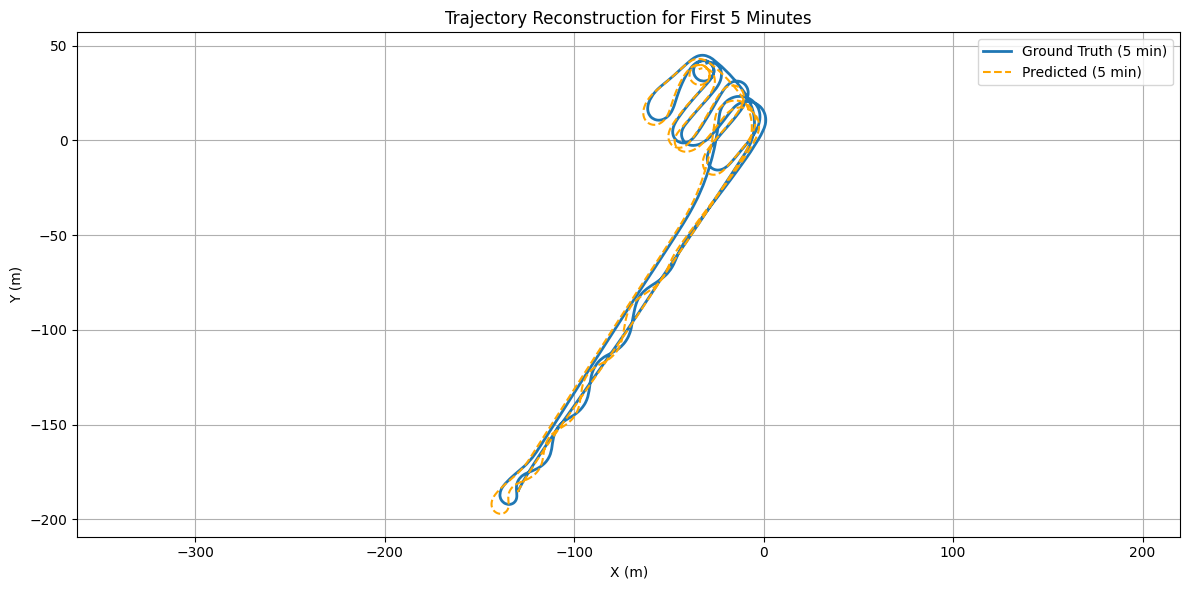

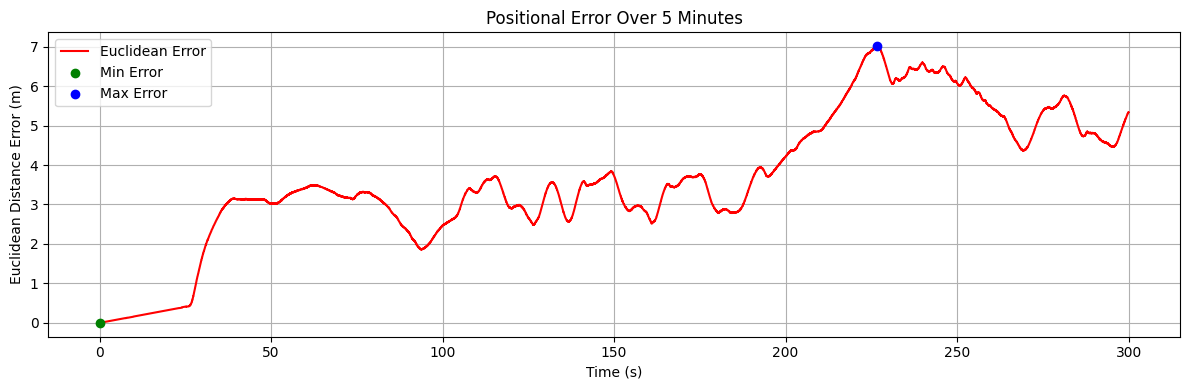

In [13]:
# Parameters
sampling_rate = 50  # Hz
duration_sec = 300  # 5 minutes
timesteps = duration_sec * sampling_rate  # 15000 samples

# Slice predictions and yaw
preds_5min = preds_unscaled[:timesteps]
yaw = test_df['ins_yaw'].values[seq_len : seq_len + timesteps]
yaw = -np.deg2rad(yaw)

# Predicted deltas in local frame
pred_dx_v = preds_5min[:, 2]
pred_dy_v = preds_5min[:, 3]

# Convert to global frame deltas
delta_x_f = pred_dx_v * np.cos(yaw) - pred_dy_v * np.sin(yaw)
delta_y_f = pred_dx_v * np.sin(yaw) + pred_dy_v * np.cos(yaw)

# Starting position
start_x = test_df['ins_pos_rel_x'].values[seq_len]
start_y = test_df['ins_pos_rel_y'].values[seq_len]

# Reconstructed global positions
pred_pos_x = np.cumsum(delta_x_f) + start_x
pred_pos_y = np.cumsum(delta_y_f) + start_y

# Ground truth positions
gt_pos_x = test_df['ins_pos_rel_x'].values[seq_len : seq_len + timesteps]
gt_pos_y = test_df['ins_pos_rel_y'].values[seq_len : seq_len + timesteps]

# Euclidean Error 
euclidean_error = np.sqrt((pred_pos_x - gt_pos_x) ** 2 + (pred_pos_y - gt_pos_y) ** 2)

#  Error Stats 
min_error = np.min(euclidean_error)
max_error = np.max(euclidean_error)
min_idx = np.argmin(euclidean_error)
max_idx = np.argmax(euclidean_error)

print(f"\n🔹 Minimum error: {min_error:.3f} m at timestep {min_idx} (time = {min_idx / sampling_rate:.2f} s)")
print(f"🔹 Maximum error: {max_error:.3f} m at timestep {max_idx} (time = {max_idx / sampling_rate:.2f} s)")


plt.figure(figsize=(12, 6))
plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth (5 min)', linewidth=2)
plt.plot(pred_pos_x, pred_pos_y, label='Predicted (5 min)', linestyle='--', color='orange')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Trajectory Reconstruction for First 5 Minutes')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.savefig("Trajectory_5min")
plt.show()


plt.figure(figsize=(12, 4))
time_axis = np.arange(timesteps) / sampling_rate  # seconds
plt.plot(time_axis, euclidean_error, color='red', label='Euclidean Error')
plt.scatter(min_idx / sampling_rate, min_error, color='green', label='Min Error', zorder=5)
plt.scatter(max_idx / sampling_rate, max_error, color='blue', label='Max Error', zorder=5)
plt.xlabel('Time (s)')
plt.ylabel('Euclidean Distance Error (m)')
plt.title('Positional Error Over 5 Minutes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Trajectory_Error_5min")
plt.show()
